In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings('ignore')

In [2]:
n_samples = 1000
x_temp = np.random.uniform(low=-10.0, high=40.0, size=n_samples)
x_sky = np.random.choice(['sunny', 'cloudy', 'rainy'], size=n_samples)
x_prec_prob = np.random.uniform(low=0.0, high=1.0, size=n_samples)
x_precip = np.random.uniform(low=0.0, high=10.0, size=n_samples)
x_humidity = np.random.uniform(low=0.0, high=100.0, size=n_samples)
x_wind_speed = np.random.uniform(low=0.0, high=20.0, size=n_samples)
y_solar_power = np.random.uniform(low=0.0, high=1000.0, size=n_samples)

x_temp_norm = (x_temp - np.mean(x_temp)) / np.std(x_temp)
x_prec_prob_norm = (x_prec_prob - np.mean(x_prec_prob)) / np.std(x_prec_prob)
x_precip_norm = (x_precip - np.mean(x_precip)) / np.std(x_precip)
x_humidity_norm = (x_humidity - np.mean(x_humidity)) / np.std(x_humidity)
x_wind_speed_norm = (x_wind_speed - np.mean(x_wind_speed)) / np.std(x_wind_speed)
y_solar_norm = (y_solar_power - np.mean(y_solar_power)) / np.std(y_solar_power)


In [3]:
y_tr = y_solar_norm[:700]
y_ts = y_solar_norm[700:]

In [4]:
sky = pd.DataFrame(x_sky)
sky = np.array(pd.get_dummies(sky).values)

In [5]:
x_data = np.concatenate([sky, x_temp_norm[:,np.newaxis], x_prec_prob_norm[:,np.newaxis], x_precip_norm[:,np.newaxis], x_humidity_norm[:,np.newaxis], x_wind_speed_norm[:,np.newaxis] ], axis = 1)

In [6]:
x_tr = x_data[:700]
x_ts = x_data[700:]

In [7]:
inputs = layers.Input(shape=(8,))
x = layers.Dense(32, activation='relu')(inputs)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)


In [8]:
class PINN(tf.keras.Model):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=50, activation=tf.nn.tanh)
        self.hidden_layer_2 = tf.keras.layers.Dense(units=50, activation=tf.nn.tanh)
        self.output_layer = tf.keras.layers.Dense(units=output_dim)

    def call(self, inputs):
        x = self.hidden_layer_1(inputs)
        x = self.hidden_layer_2(x)
        output = self.output_layer(x)
        return output


In [16]:
def equation_of_time(day):
    """Compute the equation of time for a given day"""
    B = (day - 1) * (360 / 365)
    EoT = 229.18 * (0.000075 + 0.001868 * np.cos(np.radians(B)) - 0.032077 * np.sin(np.radians(B)) \
        - 0.014615 * np.cos(2 * np.radians(B)) - 0.040849 * np.sin(2 * np.radians(B)))
    return EoT

def clear_sky_index(zenith_angle):
    """
    Compute the clear sky index for a given zenith angle
    equation of time : 균시차 - 평균 태양시와 관측되는 태양시 차이
    """
    csi = 1.0 / (1 + (6.8 / (np.cos(zenith_angle) ** 0.75)))
    return csi

def extraterrestrial_radiation(day, latitude):
    """
    Compute the extraterrestrial radiation for a given day
    외기 복사량

    """
    delta = 23.45 * np.sin(np.radians(360 * (284 + day) / 365))
    Gsc = 1367  # Solar constant
    dr = 1 + 0.033 * np.cos(np.radians(360 * day / 365))
    omega = np.arccos(-np.tan(np.radians(delta)) * np.tan(np.radians(23.45)))
    Ra = (24 * 60 / np.pi) * Gsc * dr * (omega * np.sin(np.radians(delta)) * np.sin(np.radians(latitude)) \
        + np.cos(np.radians(delta)) * np.cos(np.radians(latitude)) * np.sin(omega))
    return Ra

def clear_sky_model(latitude, longitude, day, time):
    # 라디안 각 변환
    lat_rad = np.radians(latitude)
    long_rad = np.radians(longitude)

    # 적위각 계산
    B = (day - 1) * (360 / 365)
    declination = 23.45 * np.sin(np.radians(B))

    # 지방 태양시(Local Solar Time:LST) 계산
    solar_noon = 12 + ((4 * long_rad) / np.pi) - (equation_of_time(day) / 60)

    # 시간 보정 계수 계산
    tc = 60 * (time - solar_noon)

    # 천정각 계산
    zenith_angle = np.arccos(np.sin(lat_rad) * np.sin(declination) + np.cos(lat_rad) * np.cos(declination) * np.cos(np.radians(tc)))

    # 맑은 날 기준 복사에너지 계산
    clear_sky_radiation = clear_sky_index(zenith_angle) * extraterrestrial_radiation(day, latitude) * 0.7

    return clear_sky_radiation

def photovoltaic_equation(T_air, GHI, clear_sky_radiation):
    """
    T_air (float): 온도
    GHI (float): 수평면 전일 일사량
    """
    k = 1.38e-23  # 볼츠만 상수
    q = 1.6e-19   # 기본 전하
    Eg = 1.12     # 실리콘 band gap
    A = 1         # cell 개수

    # 합선(=단락, short circuit) 전류 계산
    I_sc = (GHI / 1000) * A

    # 단선 전압 계산
    T_ref = 25
    V_oc = ((k * (T_ref + 273.15)) / q) * np.log((I_sc / A) / ((q / k) * (T_air + 273.15)) + 1)

    # fill factor = PV 모듈의 효율성
    FF = 0.7

    # 최대 전류 계산
    I_mpp = I_sc * FF

    # 최대 전압 계산
    V_mpp = V_oc - (k * (T_ref + 273.15) / q) * np.log((I_mpp / A) / ((q / k) * (T_air + 273.15)) + 1)

    # 전력 출력 계산
    P_out = I_mpp * V_mpp

    # 효율 계산
    eta = P_out / (GHI * A)

    # 실제 태양광 에너지 생성량
    power_output = eta * clear_sky_radiation * A

    return power_output

In [9]:
def clear_sky_loss(x, y):
    with tf.GradientTape() as tape:
        tape.watch(x)
        u = model(x)
        du_dx = tape.gradient(u, x)
    return tf.reduce_mean(tf.square(du_dx - y))

def photovoltaic_equation_loss(x, y):
    with tf.GradientTape() as tape:
        tape.watch(x)
        u = model(x)
        du_dx = tape.gradient(u, x)
    return tf.reduce_mean(tf.square(du_dx - y))


In [10]:
input_dim = 8
output_dim = 1
model = PINN(input_dim, output_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
num_epochs = 5000

y_tr = y_tr.reshape(-1,1)
x_train = tf.convert_to_tensor(x_tr, dtype=tf.float32)

for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        loss = clear_sky_loss(x_train, y_tr)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if epoch % 500 == 0:
        print(f"Epoch {epoch} Loss {loss.numpy():.4f}")


x_test = np.random.rand(1000, 6)
y_test = np.sin(np.sum(x_test, axis=1)).reshape(-1, 1)

predictions = model(x_ts)
mse = tf.reduce_mean(tf.square(predictions - y_ts))
#print(f"Mean Squared Error: {mse.numpy():.4f}")


Epoch 0 Loss 1.0411
Epoch 500 Loss 0.3711
Epoch 1000 Loss 0.1653
Epoch 1500 Loss 0.1029
Epoch 2000 Loss 0.0733
Epoch 2500 Loss 0.0565
Epoch 3000 Loss 0.0475
Epoch 3500 Loss 0.0414
Epoch 4000 Loss 0.0371
Epoch 4500 Loss 0.0337
Mean Squared Error: 1.5313


In [11]:
# Predict on test set
preds = model.predict(x_ts)

# Calculate mean squared error
mse = np.mean((preds - y_ts)**2)

print('Mean Squared Error:', mse)

10/10 [==============================] - 0s 1ms/step
Mean Squared Error: 1.5313396957090095


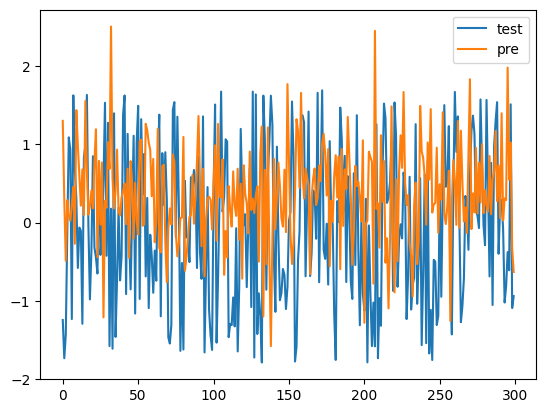

In [15]:
plt.plot(y_ts, label = 'test')
plt.plot(preds, label = 'pre')
plt.legend()
plt.show()

In [13]:
def equation_of_time(day):
    """Compute the equation of time for a given day"""
    B = (day - 1) * (360 / 365)
    EoT = 229.18 * (0.000075 + 0.001868 * np.cos(np.radians(B)) - 0.032077 * np.sin(np.radians(B)) \
        - 0.014615 * np.cos(2 * np.radians(B)) - 0.040849 * np.sin(2 * np.radians(B)))
    return EoT

def clear_sky_index(zenith_angle):
    """Compute the clear sky index for a given zenith angle"""
    csi = 1.0 / (1 + (6.8 / (np.cos(zenith_angle) ** 0.75)))
    return csi

def extraterrestrial_radiation(day, latitude):
    """Compute the extraterrestrial radiation for a given day"""
    delta = 23.45 * np.sin(np.radians(360 * (284 + day) / 365))
    Gsc = 1367  # Solar constant
    dr = 1 + 0.033 * np.cos(np.radians(360 * day / 365))
    omega = np.arccos(-np.tan(np.radians(delta)) * np.tan(np.radians(23.45)))
    Ra = (24 * 60 / np.pi) * Gsc * dr * (omega * np.sin(np.radians(delta)) * np.sin(np.radians(latitude)) \
        + np.cos(np.radians(delta)) * np.cos(np.radians(latitude)) * np.sin(omega))
    return Ra

def clear_sky_model(latitude, longitude, day, time):
    # 라디안 각 변환
    lat_rad = np.radians(latitude)
    long_rad = np.radians(longitude)

    # 적위각 계산
    B = (day - 1) * (360 / 365)
    declination = 23.45 * np.sin(np.radians(B))

    # 지방 태양시(Local Solar Time:LST) 계산
    solar_noon = 12 + ((4 * long_rad) / np.pi) - (equation_of_time(day) / 60)

    # 시간 보정 계수 계산
    tc = 60 * (time - solar_noon)

    # 천정각 계산
    zenith_angle = np.arccos(np.sin(lat_rad) * np.sin(declination) + np.cos(lat_rad) * np.cos(declination) * np.cos(np.radians(tc)))

    # 맑은 날 기준 복사에너지 계산
    clear_sky_radiation = clear_sky_index(zenith_angle) * extraterrestrial_radiation(day, latitude) * 0.7

    return clear_sky_radiation

def photovoltaic_equation(T_air, GHI, clear_sky_radiation):
    k = 1.38e-23  # 볼츠만 상수
    q = 1.6e-19   # 기본 전하
    Eg = 1.12     # 실리콘 band gap
    A = 1         # cell 개수

    # 합선(=단락, short circuit) 전류 계산
    I_sc = (GHI / 1000) * A

    # 단선 전압 계산
    T_ref = 25
    V_oc = ((k * (T_ref + 273.15)) / q) * np.log((I_sc / A) / ((q / k) * (T_air + 273.15)) + 1)

    # fill factor = PV 모듈의 효율성
    FF = 0.7

    # 최대 전류 계산
    I_mpp = I_sc * FF

    # 최대 전압 계산
    V_mpp = V_oc - (k * (T_ref + 273.15) / q) * np.log((I_mpp / A) / ((q / k) * (T_air + 273.15)) + 1)

    # 전력 출력 계산
    P_out = I_mpp * V_mpp

    # 효율 계산
    eta = P_out / (GHI * A)

    # 실제 태양광 에너지 생성량
    power_output = eta * clear_sky_radiation * A

    return power_output

In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split